# Reinforcement Learning Tutorial

### Formalizing a sequential decision problem as an MDP
Consider the following environment:
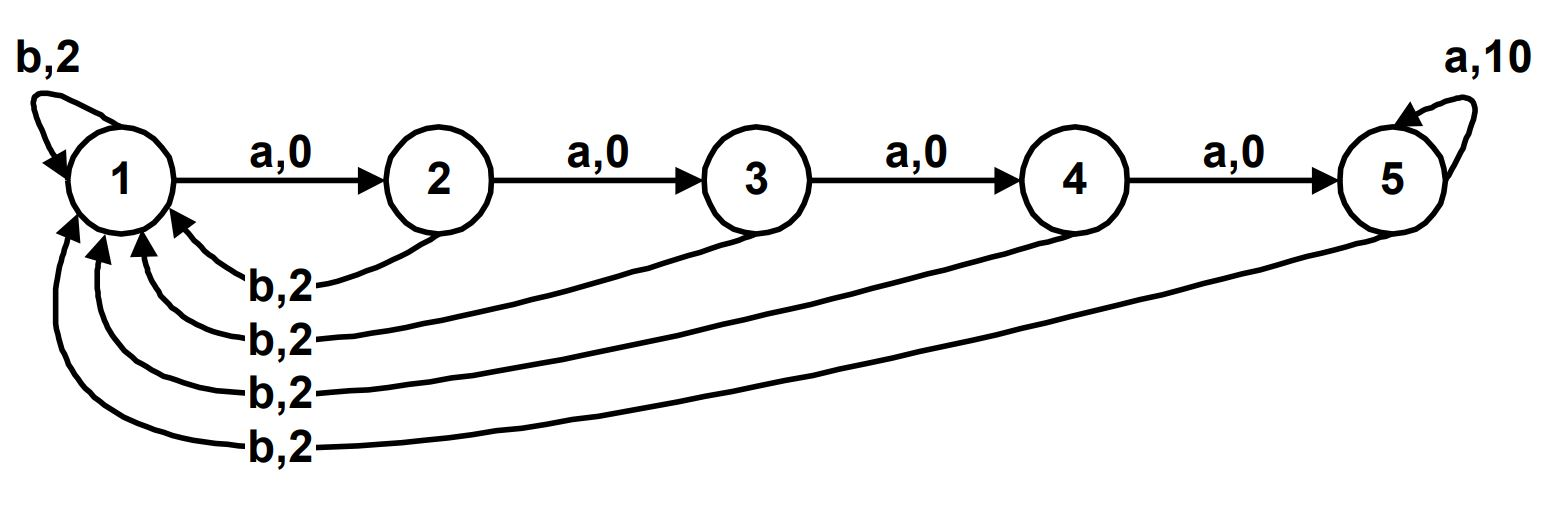

There are 5 numbered states. An agent can perform 2 actions: Action $a$ (go right) or Action $b$ (return to state $(1)$). The agent gains a reward = $2$ whenever by using action $b$ in every state or a reward = $10$ when selecting action $a$ in state $(5)$. Otherwise he gets a reward = $0$. When action a is performed in state $(5)$ the agent will remain there.

Define the transition probabilities as a numpy array of shape ($\#$Actions, $\#$States, $\#$States).

Define the reward function as a numpy array of shape ($\#$Actions, $\#$States).

Now change the transition function you defined to make it stochastic. When an agent selects an action let it happen the outcome of the other action with probability $p = 0.1$ except for the last state where it will happen with $p = 0.2$.

From "A Bayesian framework for reinforcement learning", Malcolm Strens,
https://www.ece.uvic.ca/~bctill/papers/learning/Strens_2000.pdf

Please run the following piece of code to load numpy and to define the problem's parameters

In [ ]:
import numpy as np
# Sizes of the state/action spaces
nbS, nbA = 5, 2
# Problem parameters: probability values and rewards
pr, pr_last = 0.9, 0.8
rstay, rmax = 2, 10

Let's define the transition and reward functions: for that, fill in the following code:

In [ ]:
# Transition matrices
T = np.zeros((nbA, nbS, nbS))
# Reward vectors
R = np.zeros((nbA, nbS))

# From first states
for i in range(nbS-1):
    T[0, i, i+1] = pr
    T[0, i, 0] = 1 - pr
    T[1, i, 0] = pr
    T[1, i, i+1] = 1 - pr
    R[1, i] = rstay

# From the last state
T[0, nbS-1, nbS-1] = pr_last
T[0, nbS-1, 0] = 1 - pr_last
T[1, nbS-1, 0] = pr_last
T[1, nbS-1, nbS-1] = 1 - pr_last
R[0, nbS-1] = rmax
R[1, nbS-1] = rstay

# Check that the transition matrix contains probability distributions
action_names = ['a','b']
for a in range(2):
    if np.any(np.sum(T[a,:,:],axis=1)==np.ones(nbS)):
        print('Transition matrix of action', action_names[a], 'well normalized.')
        print(T[a,:,:])
    else:
        print('WARNING: transition matrix of action', action_names[a], 'NOT normalized.')

# Reward vectors
for a in range(2):
    print('Reward for action', action_names[a])
    print(R[a,:])

### VALUE ITERATION ALGORITHM

Fill in the following function to get the VI algorithm

In [ ]:
def value_iteration(t,r,gamma,epsilon):
    v = np.max(r,axis=0)
    vtemp = np.max(r + gamma * np.dot(t,v), axis=0)
    n=0
    while np.linalg.norm(v-vtemp)>epsilon:
        v = vtemp
        # Dynamic Programming equation
        vtemp = np.max(r + gamma * np.dot(t,v), axis=0)
        n += 1
    print('VI ends after', n,'iterations.')
    return v

Use this function with the problem parameters to get the value function. 
- What happens with decreasing gamma > 0 ? 
- Same question with epsilon.

In [ ]:
V = value_iteration(T,R,gamma=0.9,epsilon=0.01)
print(V)

Please extract the optimal policy by computing the Q-value function.

In [ ]:
gamma = 0.9
# definition of the Q value 
# associated to the value function V:
Q = R + gamma * np.dot(T,V)
# the optimal policy is the greedy policy
# associated to the optimal Q value:
opt_pol = np.argmax(Q,axis=0)
print(opt_pol)

### POLICY ITERATION ALGORITHM

We are now going to implement PI: this algorithm has 2 steps:
- policy evaluation,
- policy improvement.


When evaluating the policy, we use the transition matrix and the reward vector associated to this policy. This is the purpose of the following function.

In [ ]:
def policy_expectation(transition, reward, policy):
    # reward vector
    state_reward = np.zeros(nbS, dtype=np.float64)
    # transition matrix
    trans_markov_chain = np.eye(nbS, dtype=np.float64)
    for s in range(nbS):
        # action selected by the policy for this state
        index = policy[s]
        # transition distribution from this state with this action
        trans_markov_chain[s] = transition[index, s]
        # reward associated to this state and this action
        state_reward[s] = reward[index,s]
    return state_reward, trans_markov_chain

Let's consider a policy:

In [ ]:
p = np.random.randint(0,2, size=5)
print(p)

The associated transition matrix and reward are:

In [ ]:
r, t = policy_expectation(T, R, p)
print('Transition matrix:\n', t)
print('Reward vector:\n', r)

We can now evaluate a policy given its transition matrix and its reward vector. It can be done by iterating the Bellman Equation (like in VI without the max), but in our case, we can solve the linear system of the Bellman equation using np.linalg.inv(). 

In [ ]:
def policy_evaluation(transition, reward, policy, gamma):
    # Compute the reward vector and the transition matrix
    r, tmc = policy_expectation(transition, reward, policy)
    # Compute the left side matrix of the linear system
    z = np.eye(tmc.shape[0], dtype=np.float64) - gamma * tmc
    # Inverse this matrix using linalg.inv
    z = np.linalg.inv(z)
    # Multiply the inverse by the reward vector
    v = np.dot(z, r)
    return v

Test this function on the previous arbitrary policy.

In [ ]:
v = policy_evaluation(T, R, p, 0.9)
print('Policy:', p)
print('Associated Value function:', v)


We are now ready to implement Policy Iteration. Please fill the following code for that.

In [ ]:
def policy_iteration(t, r, gamma):
    q = np.copy(r)
    # extract the greedy policy w.r.t. the reward function 
    policy = np.argmax(q, axis=0)
    # evaluate this policy, i.e. compute the associated value function
    v = policy_evaluation(t, r, policy, gamma)
    # compute the Q value associated to the value function
    q = r + gamma * np.dot(t,v)
    changed = True
    n = 0
    while changed:
        n += 1
        # POLICY IMPROVEMENT
        # extract the greedy policy w.r.t. the Q value
        new_pol = np.argmax(q, axis=0)
        print(new_pol)
        # tests if there is a change in policy
        if np.any(new_pol != policy):
            changed = True
            policy = new_pol
            # POLICY EVALUATION
            # evaluate this policy, i.e. compute the associated value function
            v = policy_evaluation(t, r, new_pol, gamma)
            # compute the Q value associated to the value function
            q = r + gamma * np.dot(t,v)
        else:
            changed = False
            print('PI ends after', n, 'iterations.')
    return policy

In [ ]:
optimal_policy = policy_iteration(T, R, gamma=0.9)
print('Optimal policy:', optimal_policy)

So far so good. With gamma = 0.9 the optimal policy is the one that pushes the agent to go always right!

Find the greatest gamma that makes the optimal policy different. What does it mean? Please interpret the result.

### REINFORCEMENT LEARNING

#### Use an OpenAI environment

There are 4 locations (labeled by different letters) and your job is to pick up the passenger at one location and drop him off in another. You receive +20 points for a successful dropoff, and lose 1 point for every timestep it takes. There is also a 10 point penalty for illegal pick-up and drop-off actions.

https://gym.openai.com/envs/Taxi-v3/

In [ ]:
import gym
# choose an environment
env = gym.make("Taxi-v3").env
# illustration of a random state
env.render()

In [ ]:
# reset the environment to a new, random state
env.reset()
env.render()

print("Action Space:", env.action_space)
print("State Space:", env.observation_space)

In [ ]:
# set a state
state = env.encode(2, 2, 3, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)

env.s = state
env.render()

In [ ]:
from IPython.display import clear_output
from time import sleep

# simulation of 50 steps
horizon = 50

# store the current epoch, the number of received penalties, and the current rewards
epochs, penalties, reward, = 0, 0, 0

# start simulation
env.reset()
done = False
while not done:
    # select a random action
    action = env.action_space.sample()
    
    # use the action, and get next state and reward
    next_state, reward, done, info = env.step(action) 
    
    # display the state of the system
    clear_output(wait=True)
    print('epoch', epochs)
    env.render()

    # penalty counter
    if reward == -10:
        penalties += 1

    # update the system state and the time step variables 
    state = next_state
    epochs += 1
    
    # stop if the horizon is reached
    if epochs==horizon:
        done = True
    sleep(.1)

#### Implement the Q learning algorithm

In [ ]:
import numpy as np
import random

# creation of the Q value function
q_table = np.zeros([env.observation_space.n, env.action_space.n])

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []


for i in range(1, 100001):
    
    # simulation initialization
    state = env.reset()
    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    # start simulation
    while not done:
        # trade-off Exploration-Exploitation
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values
        
        # apply action, get next state and reward
        next_state, reward, done, info = env.step(action) 
        
        # update the Q value function
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        # penalty counter
        if reward == -10:
            penalties += 1

        # update the system state and the time step variables 
        state = next_state
        epochs += 1
    
    # plot epoch counter
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")

#### Evaluation of the agent

In [ ]:
total_epochs, total_penalties = 0, 0
episodes = 100

for _ in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1

        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

print("Results after", episodes, "episodes:")
print("Average timesteps per episode:", total_epochs/episodes)
print(f"Average penalties per episode:", total_penalties/episodes)

#### Display the trained agent

In [ ]:
epochs, penalties, reward, = 0, 0, 0
env.reset()
done = False    
while not done:
    action = np.argmax(q_table[state]) # Exploit learned values
    next_state, reward, done, info = env.step(action) 
    
    clear_output(wait=True)
    env.render()
        
    old_value = q_table[state, action]
    next_max = np.max(q_table[next_state])
        
    new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
    q_table[state, action] = new_value

    if reward == -10:
        penalties += 1

    state = next_state
    epochs += 1
    sleep(.1)

#### Application of the lecture: implementation of the classical RL algorithms, e.g.
- Monte-Carlo,
- TD(0),
- SARSA.

In [ ]:
# ex: SARSA

import numpy as np
import random

# creation of the Q value function
q_table = np.zeros([env.observation_space.n, env.action_space.n])

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []


for i in range(1, 100001):
    
    # simulation initialization
    state = env.reset()
    epochs, penalties, reward, = 0, 0, 0
    done = False
    # trade-off Exploration-Exploitation
    if random.uniform(0, 1) < epsilon:
        action = env.action_space.sample() # Explore action space
    else:
        action = np.argmax(q_table[state]) # Exploit learned values
    
    # start simulation
    while not done:

        # apply action, get next state and reward
        next_state, reward, done, info = env.step(action)
        
        # trade-off Exploration-Exploitation
        if random.uniform(0, 1) < epsilon:
            next_action = env.action_space.sample() # Explore action space
        else:
            next_action = np.argmax(q_table[next_state]) # Exploit learned values
        
        # update the Q value function
        old_value = q_table[state, action]
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * q_table[next_state,next_action])
        q_table[state, action] = new_value

        # penalty counter
        if reward == -10:
            penalties += 1

        # update the system state and the time step variables 
        state = next_state
        action = next_action
        epochs += 1

    
    # plot epoch counter
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")

In [ ]:
# DISPLAY
epochs, penalties, reward, = 0, 0, 0
env.reset()
done = False    
while not done:
    action = np.argmax(q_table[state]) # Exploit learned values
    next_state, reward, done, info = env.step(action) 
    
    clear_output(wait=True)
    env.render()
        
    old_value = q_table[state, action]
    next_max = np.max(q_table[next_state])
        
    new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
    q_table[state, action] = new_value

    if reward == -10:
        penalties += 1

    state = next_state
    epochs += 1
    sleep(.1)

# Continuous environment and Function Approximation
Consider now the environment Mountain Car: a car is on a one-dimensional track, positioned between two "mountains". The goal is to drive up the mountain on the right; however, the car's engine is not strong enough to scale the mountain in a single pass. Therefore, the only way to succeed is to drive back and forth to build up momentum. https://gym.openai.com/envs/MountainCar-v0/

In [1]:
# IF DISPLAY ISSUES:
#from IPython import display
#import matplotlib
#import matplotlib.pyplot as plt
#%matplotlib inline
import time
import gym

env = gym.make('MountainCar-v0')
env.reset()
#img = plt.imshow(env.render(mode='rgb_array')) # only call this once
for _ in range(100):
    #img.set_data(env.render(mode='rgb_array')) # just update the data
    #display.display(plt.gcf())
    #display.clear_output(wait=True)
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    env.render()
    time.sleep(0.01)
env.close()


In [5]:
# LOAD THE FOLLOWING LIBRARIES
# YOU NEED plotting.py TO BE IN THE SAME FOLDER
%matplotlib inline
import itertools
import matplotlib
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler
import plotting
matplotlib.style.use('ggplot')

The Q-value will be approximated using a regressor. We need a regressor that can be updated each time a new sample is available. SGDRegressor is such a regressor, and the "update" can be performed using the method "partial_fit" (instead of the classical "fit"). However, SGDRegressor is a linear regressor. In order to take into account the non-linearity of the problem, we will produce many features using RBFSampler.

In [7]:
# Preprocessing: normalization to zero mean and variance one.
# We use a few samples from the observation space to do this.
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

# We use RBF kernels with different variances
# It produces 400 features
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))

FeatureUnion(transformer_list=[('rbf1', RBFSampler(gamma=5.0)),
                               ('rbf2', RBFSampler(gamma=2.0)),
                               ('rbf3', RBFSampler()),
                               ('rbf4', RBFSampler(gamma=0.5))])

We can now define the regressor that will estimate the Q-value.

In [12]:
class Estimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self):
        # We create a separate model for each action in the environment's action space. 
        # Alternatively we could somehow encode the action into the features.
        self.models = []
        for _ in range(env.action_space.n):
            model = SGDRegressor(learning_rate="constant")
            # Initial partial fit
            model.partial_fit([self.make_features(env.reset())], [0])
            self.models.append(model)
    
    def make_features(self, state):
        """
        Returns the features representing a state.
        """
        scaled = scaler.transform([state])
        features = featurizer.transform(scaled)
        return features[0]

    
    def predict(self, s, a=None):
        """
        Makes value function predictions.
        
        Args:
            s: state to make a prediction for
            a: (Optional) action to make a prediction for
            
        Returns
            If an action a is given this returns a single number as the prediction.
            If no action is given this returns a vector or predictions for all actions
            in the environment where pred[i] is the prediction for action i.
            
        """
        features = self.make_features(s)
        if not a:
            return np.array([m.predict([features])[0] for m in self.models])
        else:
            return self.models[a].predict([features])[0]
    
    # Here we use partial_fit to update the regressor
    def update(self, s, a, y):
        """
        Updates the estimator parameters for a given state and action towards the target y.
        """
        features = self.make_features(s)
        self.models[a].partial_fit([features], [y])


Given a Q-value, we can extract the greedy policy. We need also the epsilon-greedy policy that selects the actions during the learning process.

In [13]:
def make_epsilon_greedy_policy(estimator, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.
    
    Args:
        estimator: An estimator that returns q values for a given state
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(observation) # ???
        best_action = np.argmax(q_values) # ???
        A[best_action] += (1.0 - epsilon)
        return A
    
    return policy_fn

We can now implement the Q-learning algorithm with function approximation.

In [14]:
def q_learning(env, estimator, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Q-Learning algorithm using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        estimator: Action-Value function estimator
        num_episodes: Number of episodes to run for.
        discount_factor: Lambda time discount factor.
        epsilon: Chance to sample a random action.
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    for i_episode in range(num_episodes):
        last_reward = stats.episode_rewards[i_episode - 1]
        sys.stdout.flush()
        
        # The policy we're following
        policy = make_epsilon_greedy_policy(
            estimator, epsilon, env.action_space.n)
        
        # Reset the environment
        state = env.reset()
        
        # One step in the environment
        for t in itertools.count():
            
            # select action using the epsilon-greedy policy
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            
            # Take a step
            next_state, reward, done, _ = env.step(action)
    
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Current estimation of the Q-value in next_state
            # one value for each action)
            q_values_next = estimator.predict(next_state) # ???

            # New sample for Q estimation
            target = reward + discount_factor * np.max(q_values_next)# ???
            
            # Update the function approximator using our target
            estimator.update(state, action, target)
            
            print("\rStep {} @ Episode {}/{} ({})".format(t, i_episode + 1, num_episodes, last_reward), end="")
                
            if done:
                break
                
            state = next_state
    
    return stats



Ready to launch the algorithm!

In [15]:
%%time
estimator = Estimator()
stats = q_learning(env, estimator, 200, epsilon=0.05)

Step 112 @ Episode 200/200 (-117.0)CPU times: user 1min 51s, sys: 8.51 s, total: 2min
Wall time: 1min 59s


Useful statistics on the learning process:

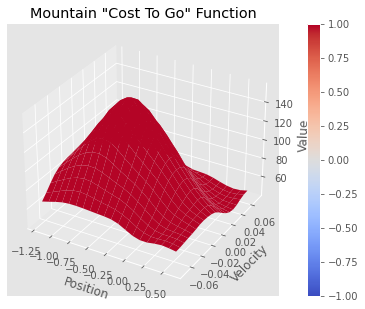

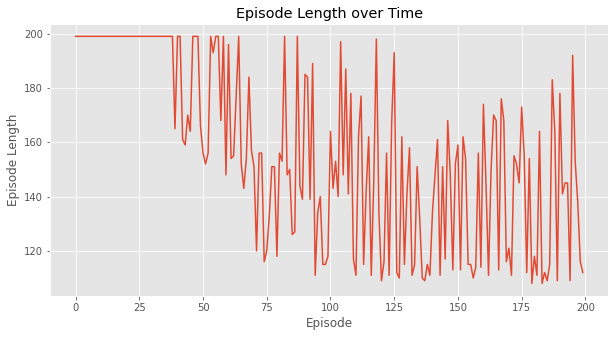

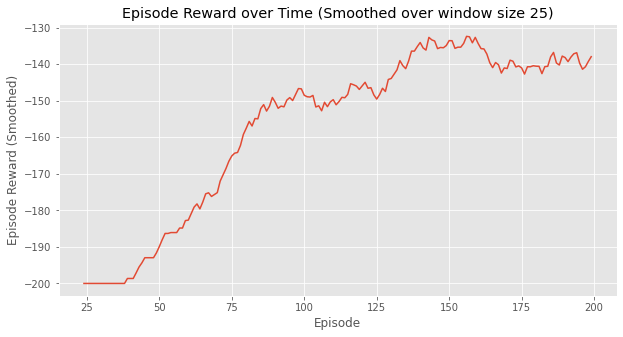

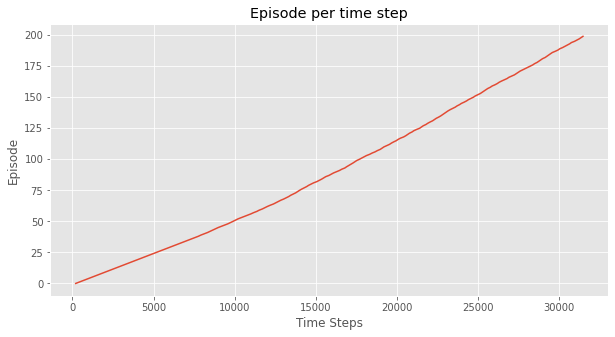

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [16]:
# some statistics
plotting.plot_cost_to_go_mountain_car(env, estimator)
plotting.plot_episode_stats(stats, smoothing_window=25)

Let's display the final behaviour:

In [18]:
env.reset()
q_values = estimator.predict(env.state)
best_action = np.argmax(q_values)
for _ in range(100):
    next_state, reward, done, _ = env.step(best_action)
    q_values = estimator.predict(next_state)
    best_action = np.argmax(q_values)
    env.render()
    time.sleep(0.01)
env.close()

Bad behaviour ? Let's find better settings:
- Other features representing the state
- Change the learning rate of SGDRegressor
- Use another regressor (with an available partial_fit method)
- Use another target
- Modify epsilon, gamma, ...

Please take some notes on the impact of these changes on the learning process.